In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


country_data = pd.read_csv('data/country.csv',encoding='latin-1')
country_data = country_data.astype(str)
sci_data = pd.read_csv('data/sci.csv',encoding='latin-1').astype(str)
Lat = country_data[['alpha-2','Lat']]
Long = country_data[['alpha-2','Long']]

# merge GDP and SCI datasets
merged = sci_data.merge(Lat,
                            how='left',
                            left_on='user_loc',
                            right_on = 'alpha-2')
merged = merged.merge(Lat,
                        how='left',
                        left_on='fr_loc',
                        right_on='alpha-2',
                        suffixes=('_user','_fr'))
merged = merged.merge(Long,
                      how='left',
                            left_on='user_loc',
                            right_on = 'alpha-2')
merged = merged.merge(Long,
                        how='left',
                        left_on='fr_loc',
                        right_on='alpha-2',
                        suffixes=('_user','_fr'))
merged = merged.drop(columns=['alpha-2_user','alpha-2_fr'])
print(merged[:40])


   user_loc fr_loc scaled_sci Migrants_from_fr  Lat_user               Lat_fr  \
0        AE     AE    1318515               ..  24.46667             24.46667   
1        AE     AG       7764               ..  24.46667   17.133329999999997   
2        AE     AL       2836               ..  24.46667             41.33333   
3        AE     AM       4174               ..  24.46667             40.18333   
4        AE     AO       2954               ..  24.46667            -8.833333   
5        AE     AR        887               ..  24.46667            -34.66667   
6        AE     AT       5111               ..  24.46667             48.21667   
7        AE     AU      14937               ..  24.46667  -33.883340000000004   
8        AE     AW       4069               ..  24.46667                12.55   
9        AE     AZ       3983               ..  24.46667   40.366659999999996   
10       AE     BA       6483               ..  24.46667   43.866659999999996   
11       AE     BB       422

In [29]:
# cleaning data to remove NA values from GDP
merged['Lat_user'] = pd.to_numeric(merged['Lat_user'], errors='coerce')
merged['Lat_fr'] = pd.to_numeric(merged['Lat_fr'], errors='coerce')
merged['Long_user'] = pd.to_numeric(merged['Long_user'], errors='coerce')
merged['Long_fr'] = pd.to_numeric(merged['Long_fr'], errors='coerce')
merged = merged[merged['Lat_user'].notna()]
merged = merged[merged['Lat_fr'].notna()]
merged = merged[merged['Long_user'].notna()]
merged = merged[merged['Long_fr'].notna()]

merged['Lat_user'] = merged['Lat_user'].astype(float)
merged['Lat_fr'] = merged['Lat_fr'].astype(float)
merged['Long_user'] = merged['Long_user'].astype(float)
merged['Long_fr'] = merged['Long_fr'].astype(float)
print(merged[:40])


   user_loc fr_loc scaled_sci Migrants_from_fr  Lat_user     Lat_fr  \
0        AE     AE    1318515               ..  24.46667  24.466670   
1        AE     AG       7764               ..  24.46667  17.133330   
2        AE     AL       2836               ..  24.46667  41.333330   
3        AE     AM       4174               ..  24.46667  40.183330   
4        AE     AO       2954               ..  24.46667  -8.833333   
5        AE     AR        887               ..  24.46667 -34.666670   
6        AE     AT       5111               ..  24.46667  48.216670   
7        AE     AU      14937               ..  24.46667 -33.883340   
8        AE     AW       4069               ..  24.46667  12.550000   
9        AE     AZ       3983               ..  24.46667  40.366660   
10       AE     BA       6483               ..  24.46667  43.866660   
11       AE     BB       4221               ..  24.46667  13.100000   
12       AE     BD      87354          1044505  24.46667  23.700000   
13    

In [30]:
import math
# https://gist.github.com/rochacbruno/2883505
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km
    lat1_rad = lat1.map(math.radians)
    lon1_rad = lon1.map(math.radians)
    lat2_rad = lat2.map(math.radians)
    lon2_rad = lon2.map(math.radians)
    
    dlat = lat2_rad-lat1_rad
    dlon = lon2_rad-lon1_rad
    
    dlat_sin = (dlat/2).map(math.sin)
    lat1_rad_cos = (lat1_rad).map(math.cos)
    lat2_rad_cos = (lat2_rad).map(math.cos)
    dlon_sin = (dlon/2).map(math.sin)
    
    a = dlat_sin * dlat_sin + lat1_rad_cos * lat2_rad_cos * dlon_sin * dlon_sin
    
    a_sqrt = a.map(math.sqrt)
    one_minus_a_sqrt = (1-a).map(math.sqrt)
    a_atan2 = pd.Series(list(map(math.atan2, a_sqrt, one_minus_a_sqrt)))
    #a_atan2 = (a_sqrt, one_minus_a_sqrt).map(math.atan2)
    
    c = 2 * a_atan2
    d = radius * c

    return d

#coords_1 = (52.2296756, 21.0122287)
#coords_2 = (52.406374, 16.9251681)

#print geopy.distance.vincenty(coords_1, coords_2).km
    
#print(merged['Lat_fr'])
merged["distance_between"] = distance((merged['Lat_user'], merged['Long_user']), (merged['Lat_fr'], merged['Long_fr']))

In [31]:
merged.isna().idxmin()

user_loc            0
fr_loc              0
scaled_sci          0
Migrants_from_fr    0
Lat_user            0
Lat_fr              0
Long_user           0
Long_fr             0
distance_between    0
dtype: int64

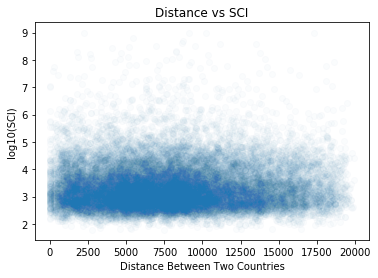

In [32]:
merged['scaled_sci'] = pd.to_numeric(merged['scaled_sci'], errors='coerce')
merged['SCI_log10'] = np.log10(merged['scaled_sci'])


plt.scatter(merged['distance_between'], merged['SCI_log10'], alpha = 0.02)
plt.xlabel('Distance Between Two Countries')
plt.ylabel('log10(SCI)')
plt.title('Distance vs SCI')
plt.show()

In [33]:
merged = merged.dropna()
merged.drop(merged[merged["distance_between"] == 0].index, inplace = True) 

print(merged)
#extracting required data
corr_data = merged[["user_loc", "fr_loc", "scaled_sci", "distance_between"]]
print(corr_data)

      user_loc fr_loc  scaled_sci Migrants_from_fr  Lat_user     Lat_fr  \
1           AE     AG        7764               ..  24.46667  17.133330   
2           AE     AL        2836               ..  24.46667  41.333330   
3           AE     AM        4174               ..  24.46667  40.183330   
4           AE     AO        2954               ..  24.46667  -8.833333   
5           AE     AR         887               ..  24.46667 -34.666670   
...        ...    ...         ...              ...       ...        ...   
28554       SN     GR        2363               ..  14.63333  38.000000   
28555       SN     GT         603               ..  14.63333  14.633330   
28557       SN     GW     1109020            28756  14.63333  11.866670   
28558       SN     GY        5990               ..  14.63333   6.766667   
28559       SN     HK         420               ..  14.63333  22.266670   

       Long_user    Long_fr  distance_between  SCI_log10  
1       54.41667  -61.83333      11701.0

In [34]:
#using ranksums to get Wilcoxon Rank Sum Test p value on two samples: scaled_sci and abs_diff_gdp
from scipy.stats import ranksums
ranksums(corr_data["scaled_sci"], corr_data["distance_between"])

RanksumsResult(statistic=-89.28206513684958, pvalue=0.0)

In [35]:
#using spearmanr to get the spearman coeffecient of the two samples
from scipy.stats import spearmanr
sp_coef = spearmanr(corr_data["scaled_sci"], corr_data["distance_between"])
print(sp_coef)

SpearmanrResult(correlation=0.005326306295690879, pvalue=0.41174947244523974)
